<a href="https://colab.research.google.com/github/chikusih716/mycarproject/blob/main/imaginary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install mne

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.5/7.5 MB 37.6 MB/s eta 0:00:00


In [ ]:
import mne
from mne.datasets import eegbci
from mne.time_frequency import psd_array_welch
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt

In [ ]:
# Step 1: Load the data for subject 1
# Run 1: Baseline (eyes open)
# Run 4: Motor imagery (left fist)
subject = 1
runs = [1, 4]
raw_files = eegbci.load_data(subject, runs, update_path=True)

Using default location ~/mne_data for EEGBCI...
Creating /root/mne_data


Attempting to create new mne-python configuration file:
/root/.mne/mne-python.json
Could not read the /root/.mne/mne-python.json json file during the writing. Assuming it is empty. Got: Expecting value: line 1 column 1 (char 0)
Download complete in 06s (3.7 MB)


In [ ]:
# Load raw data
raw_baseline = mne.io.read_raw_edf(raw_files[0], eog=['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'], preload=True, verbose=False)
raw_imagery = mne.io.read_raw_edf(raw_files[1], eog=['EXG1', 'EXG2', 'EXG3', 'EXG4', 'EXG5', 'EXG6', 'EXG7', 'EXG8'], preload=True, verbose=False)


Using matplotlib as 2D backend.


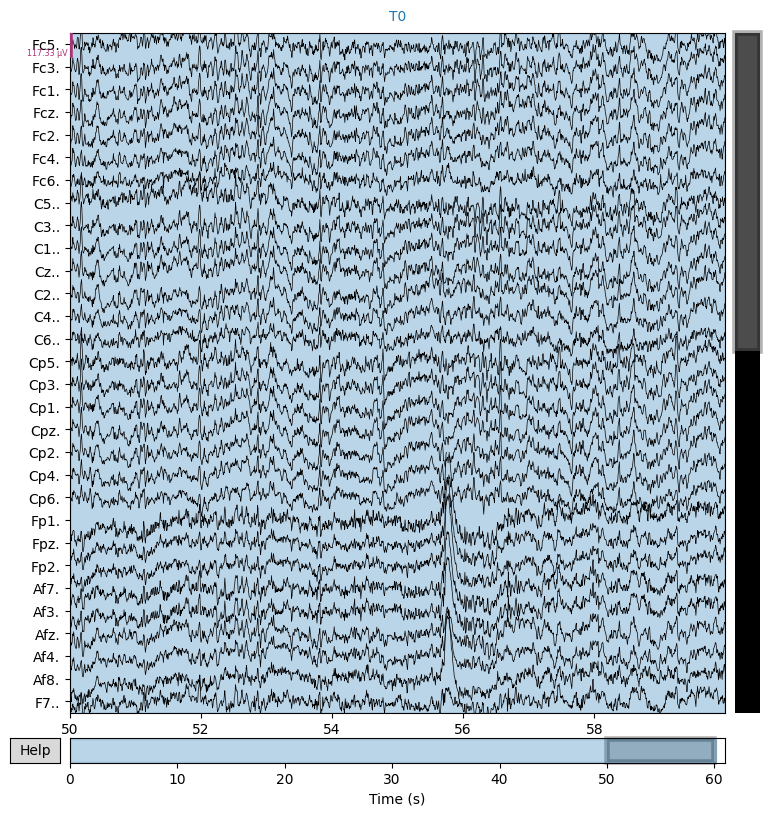

In [ ]:
raw_baseline.plot(start=50, duration=10, n_channels=30, scalings='auto')
plt.show()

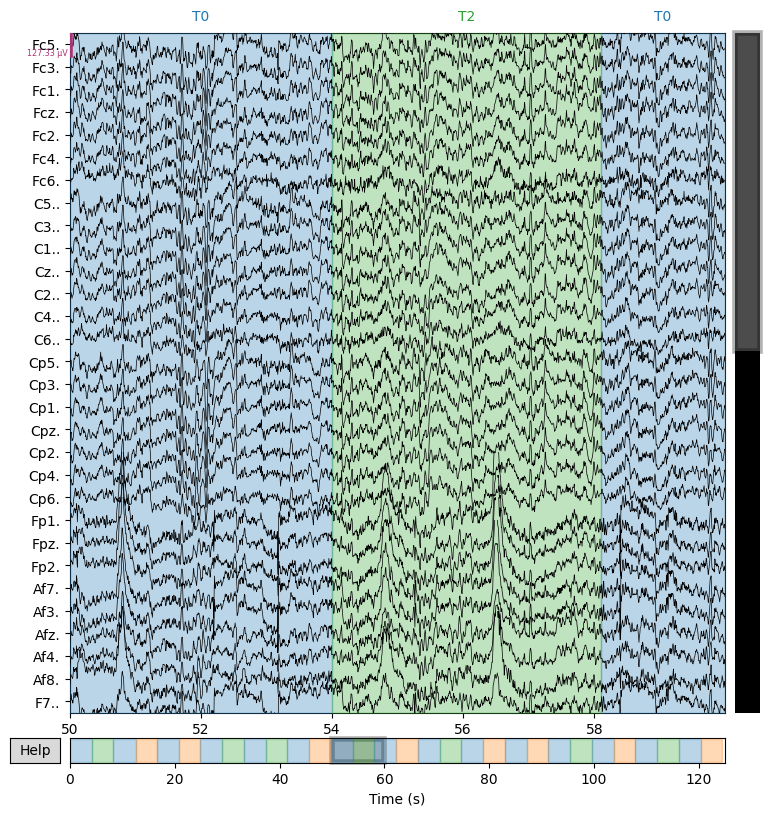

In [ ]:
raw_imagery.plot(start=50, duration=10, n_channels=30, scalings='auto')
plt.show()

In [ ]:
# Standardize channel names and set montage
eegbci.standardize(raw_baseline)
eegbci.standardize(raw_imagery)
montage = mne.channels.make_standard_montage('standard_1020')
raw_baseline.set_montage(montage, on_missing='warn')
raw_imagery.set_montage(montage, on_missing='warn')


<RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>

In [ ]:
# Filter the data (bandpass 1-40 Hz)
raw_baseline.filter(1, 40, fir_design='firwin')
raw_imagery.filter(1, 40, fir_design='firwin')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 529 samples (3.306 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 4

<RawEDF | S001R04.edf, 64 x 20000 (125.0 s), ~9.8 MiB, data loaded>

In [ ]:
# Step 2: Epoching
# For baseline: Create fixed-length epochs of 4 seconds (take 15 for consistency)
epochs_baseline = mne.make_fixed_length_epochs(raw_baseline, duration=4.0, preload=True)
epochs_baseline = epochs_baseline[:15]  # Limit to 15 epochs


Not setting metadata
15 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 15 events and 640 original time points ...
0 bad epochs dropped


In [ ]:
# For imagery: Extract events from annotations
# In this dataset, 'T0' is rest, 'T1' is left fist imagery
events, event_id = mne.events_from_annotations(raw_imagery)
# Filter for 'T1' events (left fist imagery)
t1_events = events[events[:, 2] == event_id['T1']]
epochs_imagery = mne.Epochs(raw_imagery, t1_events, {'left_fist': event_id['T1']},
                            tmin=0, tmax=4.0, baseline=None, preload=True)
epochs_imagery = epochs_imagery[:15]  # Limit to 15 epochs


Used Annotations descriptions: [np.str_('T0'), np.str_('T1'), np.str_('T2')]
Not setting metadata
8 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 8 events and 641 original time points ...
0 bad epochs dropped


In [ ]:
# Step 3: Compute PSD
sfreq = raw_baseline.info['sfreq']
fmin, fmax = 1, 40
n_fft = 256  # Adjust based on your need

In [ ]:
# PSD for baseline
psds_baseline, freqs = psd_array_welch(epochs_baseline.get_data(), sfreq=sfreq,
                                       fmin=fmin, fmax=fmax, n_fft=n_fft, n_overlap=n_fft//2,
                                       n_per_seg=n_fft, average='mean')


Effective window size : 1.600 (s)


In [ ]:
# PSD for imagery
psds_imagery, _ = psd_array_welch(epochs_imagery.get_data(), sfreq=sfreq,
                                  fmin=fmin, fmax=fmax, n_fft=n_fft, n_overlap=n_fft//2,
                                  n_per_seg=n_fft, average='mean')

Effective window size : 1.600 (s)


In [ ]:
# Step 4: Extract band powers (alpha: 8-13 Hz, beta: 13-30 Hz)
# Average over frequency bins for each band
alpha_idx = np.where((freqs >= 8) & (freqs <= 13))[0]
beta_idx = np.where((freqs >= 13) & (freqs <= 30))[0]


In [ ]:
# Mean power per epoch, per channel, per band (convert to dB: 10 * log10(power))
alpha_baseline = 10 * np.log10(np.mean(psds_baseline[:, :, alpha_idx], axis=2))
beta_baseline = 10 * np.log10(np.mean(psds_baseline[:, :, beta_idx], axis=2))
alpha_imagery = 10 * np.log10(np.mean(psds_imagery[:, :, alpha_idx], axis=2))
beta_imagery = 10 * np.log10(np.mean(psds_imagery[:, :, beta_idx], axis=2))


In [ ]:
# Average over epochs
alpha_baseline_avg = np.mean(alpha_baseline, axis=0)
beta_baseline_avg = np.mean(beta_baseline, axis=0)
alpha_imagery_avg = np.mean(alpha_imagery, axis=0)
beta_imagery_avg = np.mean(beta_imagery, axis=0)

In [ ]:
# Step 5: Get channel indices for C3, C4, Cz
ch_names = epochs_baseline.ch_names
c3_idx = ch_names.index('C3')
c4_idx = ch_names.index('C4')
cz_idx = ch_names.index('Cz')

In [ ]:
# Print average powers
print("Average Alpha Power (dB):")
print(f"C3 - Baseline: {alpha_baseline_avg[c3_idx]:.2f}, Imagery: {alpha_imagery_avg[c3_idx]:.2f}")
print(f"C4 - Baseline: {alpha_baseline_avg[c4_idx]:.2f}, Imagery: {alpha_imagery_avg[c4_idx]:.2f}")
print(f"Cz - Baseline: {alpha_baseline_avg[cz_idx]:.2f}, Imagery: {alpha_imagery_avg[cz_idx]:.2f}")


Average Alpha Power (dB):
C3 - Baseline: -103.85, Imagery: -105.35
C4 - Baseline: -105.84, Imagery: -107.05
Cz - Baseline: -104.85, Imagery: -105.24


In [ ]:
print("\nAverage Beta Power (dB):")
print(f"C3 - Baseline: {beta_baseline_avg[c3_idx]:.2f}, Imagery: {beta_imagery_avg[c3_idx]:.2f}")
print(f"C4 - Baseline: {beta_baseline_avg[c4_idx]:.2f}, Imagery: {beta_imagery_avg[c4_idx]:.2f}")
print(f"Cz - Baseline: {beta_baseline_avg[cz_idx]:.2f}, Imagery: {beta_imagery_avg[cz_idx]:.2f}")


Average Beta Power (dB):
C3 - Baseline: -109.88, Imagery: -109.53
C4 - Baseline: -111.21, Imagery: -110.96
Cz - Baseline: -110.26, Imagery: -109.76


In [ ]:
# Step 6: Statistical test (paired t-test for beta at C4)
# The number of epochs for baseline and imagery differ (15 vs 8).
# For a paired t-test, the arrays must have the same number of observations.
# We will use the first 8 epochs from the baseline condition to match the imagery condition.
t_stat, p_val = stats.ttest_rel(beta_baseline[:8, c4_idx], beta_imagery[:, c4_idx])
print(f"\nPaired t-test for Beta Power at C4: t-stat = {t_stat:.2f}, p-value = {p_val:.4f}")


Paired t-test for Beta Power at C4: t-stat = -3.07, p-value = 0.0181


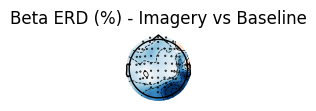

In [ ]:
 Plot topographic map of beta ERD (difference)
erd_beta = (beta_imagery_avg - beta_baseline_avg) / beta_baseline_avg * 100  # Percentage change
fig = mne.viz.plot_topomap(erd_beta, epochs_baseline.info, show=False)
plt.title('Beta ERD (%) - Imagery vs Baseline')
plt.show()

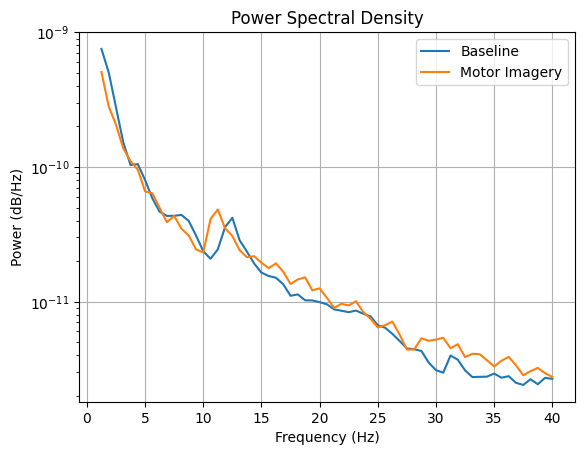

In [ ]:
# Optional: Plot the PSD for visualization
plt.figure()
plt.semilogy(freqs, np.mean(psds_baseline, axis=(0,1)), label='Baseline')
plt.semilogy(freqs, np.mean(psds_imagery, axis=(0,1)), label='Motor Imagery')
plt.title('Power Spectral Density')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power (dB/Hz)')
plt.legend()
plt.grid(True)
plt.show()